In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import os
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout , BatchNormalization, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import random
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [4]:
# the data_path is obtained after operations in the data_exploration.ipynb
data_path = 'data/redistributed'
train_path = Path(data_path) / 'train'
test_path = Path(data_path) / 'test'
val_path = Path(data_path) / 'val'

LABELS = ['NORMAL', 'PNEUMONIA']
IMG_SIZE = 224
GRAYSCALE = False
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 0.001
color_mode = 'grayscale' if GRAYSCALE else 'rgb'

# Loading Dataset

In [5]:
train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED
)

val = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

test = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 6293 files belonging to 2 classes.
Found 586 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


# Data Preprocessing

## Data Normalization

In [6]:
normalization_layer = Rescaling(1./255)

train = train.map(lambda x, y: (normalization_layer(x), y))
val = val.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))

## Data optimization

In [7]:
# use tensorflow to prefetch data for better performance
train_ds = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
for images, labels in train_ds.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

for images, labels in val_ds.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

for images, labels in test_ds.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

Image shape: (16, 224, 224, 3), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>
Image shape: (16, 224, 224, 3), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>
Image shape: (16, 224, 224, 3), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>


# Model Building

In [11]:
def build_xception_model(optimizer, metrics, loss_function, input_shape):
    base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

    # Freeze the layers in the base model
    base_model.trainable = False

    # Build Model 
    model = Sequential()

    # Base Model 
    model.add(base_model)

    # Batch Normalization
    model.add(BatchNormalization())

    # Dropout Layer
    model.add(Dropout(0.45)) 

    # Dense Layer 1
    model.add(Dense(220, activation='relu'))

    # Dropout Layer
    model.add(Dropout(0.25)) 

    # Dense Layer 2 
    model.add(Dense(60,activation='relu'))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, 
                        loss=loss_function,
                        metrics=metrics)

    return model

loss_function, optimizer = BinaryFocalCrossentropy(), Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
xception_model = build_xception_model(optimizer=optimizer,
                                metrics=METRICS, 
                                loss_function=loss_function,
                                input_shape=(IMG_SIZE,IMG_SIZE,3))
xception_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,333,773 (81.38 MB)

 Trainable params: 468,197 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

# Model training

In [12]:
train_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_type = 'vgg16'

# callback to reduce learning rate when the model stops improving
lr_reduction_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)

# save best model
checkpoint_filepath = os.path.join('models', model_type, train_time, "checkpoint.model.keras")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# tensorboard callback
log_dir = os.path.join("logs", model_type, train_time)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [13]:
history = xception_model.fit(train_ds, 
                    epochs=EPOCHS, 
                    validation_data=val_ds, 
                    callbacks=[lr_reduction_callback, model_checkpoint_callback, tensorboard_callback])

Epoch 1/15


394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8338 - loss: 0.1623
Epoch 1: val_accuracy improved from -inf to 0.91297, saving model to models/vgg16/20250109-113027/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 62s 142ms/step - accuracy: 0.8339 - loss: 0.1621 - val_accuracy: 0.9130 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 2/15
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9079 - loss: 0.0619
Epoch 2: val_accuracy improved from 0.91297 to 0.92662, saving model to models/vgg16/20250109-113027/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.9080 - loss: 0.0619 - val_accuracy: 0.9266 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 3/15
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9267 - loss: 0.0504
Epoch 3: val_accuracy improved from 0.92662 to 0.94369, saving model to models/vgg16/20250109-113027/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9267 - loss: 0.0504 - val_accuracy: 

In [14]:
# load best model
checkpoint_filepath = "models/vgg16/20250108-220943/checkpoint.model.keras"
model = load_model(checkpoint_filepath)

# Model evaluation

In [15]:
res_dir = os.path.join("res", model_type, train_time)
os.makedirs(res_dir, exist_ok=True)

In [16]:
print("Test Set Evaluation")
loss, accuracy = model.evaluate(test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy * 100}%")

Test Set Evaluation


2025-01-09 11:40:32.075156: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1629] failed to alloc 4294967296 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-01-09 11:40:32.075693: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1629] failed to alloc 3865470464 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-01-09 11:40:32.075719: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1629] failed to alloc 3478923264 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-01-09 11:40:32.075729: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1629] failed to alloc 3131030784 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory


: 

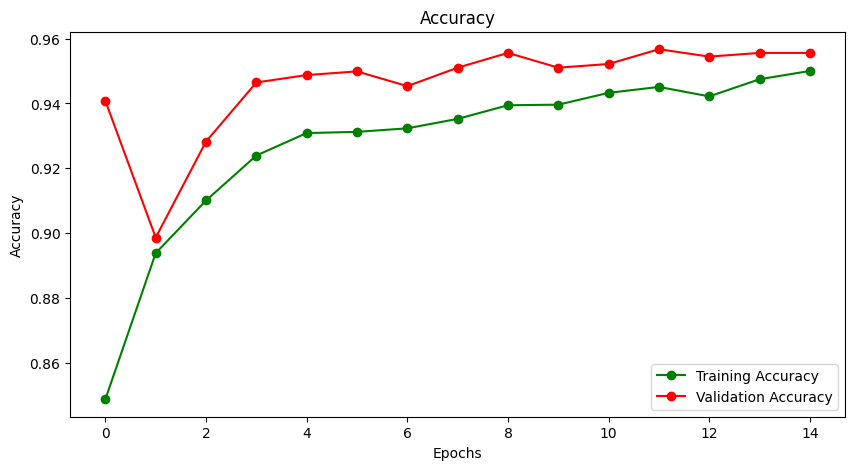

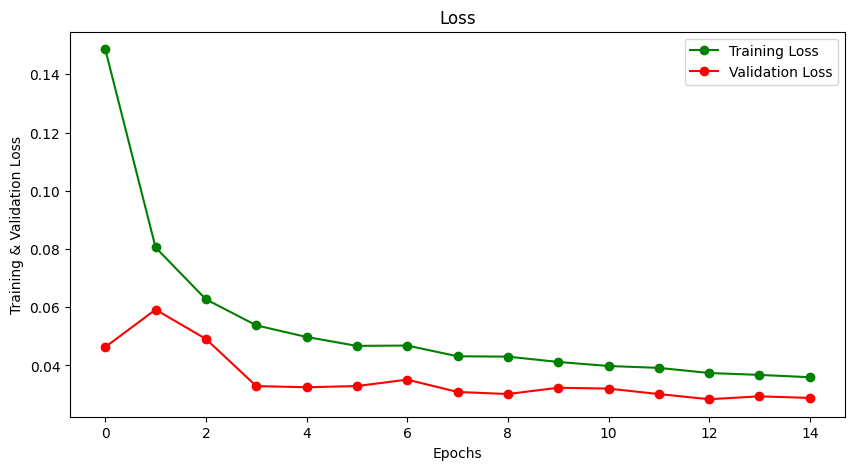

In [16]:
x_epochs = [i for i in range(EPOCHS)]

# train metrics
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# validation metrics
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot and save Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(x_epochs, train_acc, 'go-', label='Training Accuracy')
plt.plot(x_epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(os.path.join(res_dir, "training_accuracy.png"))
plt.show()

# Plot and save Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(x_epochs, train_loss, 'g-o', label='Training Loss')
plt.plot(x_epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Loss")
plt.savefig(os.path.join(res_dir, "training_loss.png"))
plt.show()

In [17]:
predictions = (model.predict(test) > 0.5).astype(int) # for binary classification
y_pred = predictions.reshape(predictions.shape[0])
y_pred

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [18]:
y_true = []
for _, labels in test.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

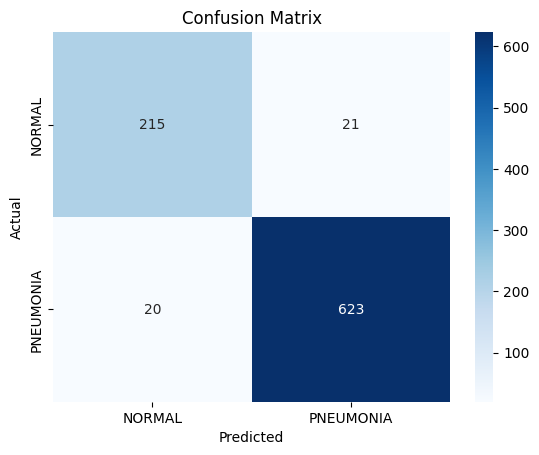

In [19]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABELS,
            yticklabels=LABELS,)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=LABELS, index=LABELS)
conf_matrix_df.to_csv(os.path.join(res_dir, "confusion_matrix.csv"))

In [20]:
report = classification_report(y_true, y_pred, target_names=LABELS)
print(report)

# save classification report
with open(os.path.join(res_dir, "classification_report.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91       236
   PNEUMONIA       0.97      0.97      0.97       643

    accuracy                           0.95       879
   macro avg       0.94      0.94      0.94       879
weighted avg       0.95      0.95      0.95       879

